In [66]:
# # Load COCO dataset
data_dir ="/content/drive/MyDrive/techgium/(224x224)Object segmentation.v2i.coco-segmentation/train"  # Path to COCO dataset directory
# ann_file_train = "/content/drive/MyDrive/techgium/(224x224)Object segmentation.v2i.coco-segmentation/train/_annotations.coco.json"  # COCO annotation file for training set
# ann_file_val = "/content/drive/MyDrive/techgium/(224x224)Object segmentation.v2i.coco-segmentation/valid/_annotations.coco.json"  # COCO annotation file for validation set
# image_dir = 'train2017'  # Directory containing training images



In [67]:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Model
from pycocotools.coco import COCO



In [68]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))



Num GPUs Available:  1


In [69]:
# Define the input shape
input_shape = (224, 224, 3)  # Adjust according to your input image size




In [70]:

# Load MobileNet model pretrained on ImageNet without the top (classification) layer
base_model = MobileNet(input_shape=input_shape, include_top=False)



In [71]:
# Define the output segmentation layer
num_classes = 1  # Number of classes
output = Conv2D(num_classes, (1, 1), activation='sigmoid')(base_model.output)
output = UpSampling2D(size=(32, 32), interpolation='bilinear')(output)  # Upsample to match input size



In [72]:
# Create the model
model = Model(inputs=base_model.input, outputs=output)


In [73]:

# Compile the model (you can use appropriate loss function and optimizer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [74]:
# Define function to load COCO dataset
def load_coco_dataset(data_dir, ann_file):
    coco = COCO(os.path.join(data_dir, ann_file))
    return coco



In [75]:
# # Define function to load and preprocess COCO data
# def load_coco_data(coco, image_id):
#     image_info = coco.loadImgs(image_id)[0]
#     image = tf.keras.preprocessing.image.load_img(
#         os.path.join(data_dir, image_info['file_name']),
#         target_size=input_shape[:2]
#     )
#     image = tf.keras.preprocessing.image.img_to_array(image)
#     image = tf.keras.applications.mobilenet.preprocess_input(image)

#     ann_ids = coco.getAnnIds(imgIds=image_info['id'], iscrowd=None)
#     anns = coco.loadAnns(ann_ids)

#     mask = np.zeros((image_info['height'], image_info['width'], num_classes))
#     for ann in anns:
#         if ann['category_id'] == 1:  # Assuming "product" has category ID 1
#             mask += coco.annToMask(ann)
#     mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
#     return image, mask

def load_coco_data(coco, image_id):
    image_info = coco.loadImgs(image_id)[0]
    image = tf.keras.preprocessing.image.load_img(
        os.path.join(data_dir, image_info['file_name']),
        target_size=input_shape[:2]
    )
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.keras.applications.mobilenet.preprocess_input(image)

    ann_ids = coco.getAnnIds(imgIds=image_info['id'], iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((image_info['height'], image_info['width']))
    for ann in anns:
        if ann['category_id'] == 1:  # Assuming "product" has category ID 1
            mask += coco.annToMask(ann)
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    return image, mask


In [76]:
# Define a generator function to yield batches of training data
def data_generator(batch_size, coco, image_ids):
    while True:
        np.random.shuffle(image_ids)
        for i in range(0, len(image_ids), batch_size):
            batch_image_ids = image_ids[i:i+batch_size]
            batch_images = []
            batch_masks = []
            for image_id in batch_image_ids:
                image, mask = load_coco_data(coco, image_id)
                batch_images.append(image)
                batch_masks.append(mask)
            yield np.array(batch_images), np.array(batch_masks)



In [77]:
# Train the model
batch_size = 8  # Change batch size according to your preference
epochs = 10  # Change the number of epochs according to your preference



In [78]:
print(data_dir)

/content/drive/MyDrive/techgium/(224x224)Object segmentation.v2i.coco-segmentation/train


In [79]:
# Load training data
train_data_dir =r"/content/drive/MyDrive/techgium/(224x224)Object segmentation.v2i.coco-segmentation/train/"
train_ann_file = r"/content/drive/MyDrive/techgium/(224x224)Object segmentation.v2i.coco-segmentation/annotations/_train_annotations.coco.json"
coco_train = load_coco_dataset(train_data_dir, train_ann_file)
train_image_ids = coco_train.getImgIds()

steps_per_epoch = len(train_image_ids) // batch_size
model.fit(
    data_generator(batch_size, coco_train, train_image_ids),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1
)



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Epoch 1/10
41/41 [==============================] - 131s 3s/step - loss: 0.1959 - accuracy: 0.9225
Epoch 2/10
41/41 [==============================] - 4s 57ms/step - loss: 0.1036 - accuracy: 0.9537
Epoch 3/10
41/41 [==============================] - 2s 51ms/step - loss: 0.0924 - accuracy: 0.9584
Epoch 4/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0897 - accuracy: 0.9593
Epoch 5/10
41/41 [==============================] - 2s 40ms/step - loss: 0.0901 - accuracy: 0.9593
Epoch 6/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0851 - accuracy: 0.9618
Epoch 7/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0881 - accuracy: 0.9611
Epoch 8/10
41/41 [==============================] - 2s 39ms/step - loss: 0.0863 - accuracy: 0.9626
Epoch 9/10
41/41 [==============================] - 2s 51ms/step - loss: 0.0853 - accuracy: 0.9626
Epoch 10/10
41/41 [=======

In [80]:
# Save the trained model
model.save('/content/drive/MyDrive/techgium/semantic_segmentation_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 410ms/step


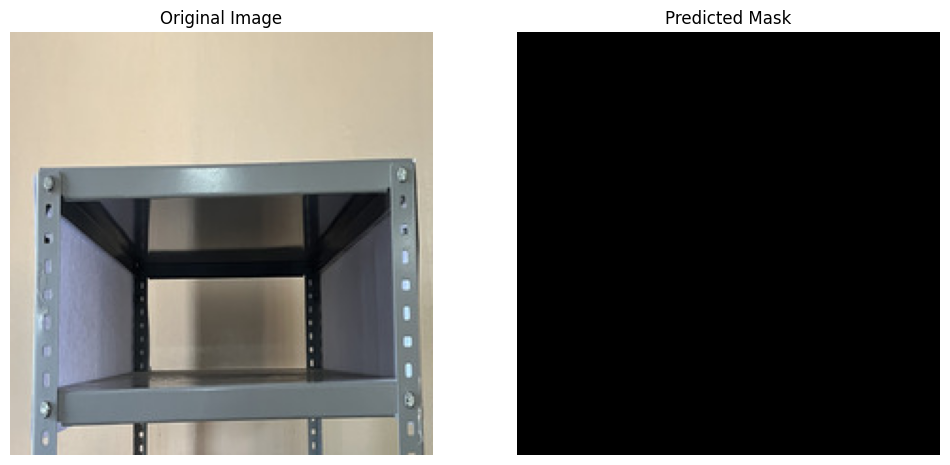

In [84]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/content/drive/MyDrive/techgium/semantic_segmentation_model.h5')

# Define input shape
input_shape = (224, 224)

# Function to preprocess input image
def preprocess_input_image(image_path):
    image = load_img(image_path, target_size=input_shape)
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = tf.keras.applications.mobilenet.preprocess_input(image_array)
    return image_array

# Function to perform prediction
def predict_image_segmentation(model, image_path):
    # Preprocess input image
    input_image = preprocess_input_image(image_path)
    # Make prediction
    prediction = model.predict(input_image)
    # Threshold prediction to binary mask
    binary_mask = prediction > 0.5  # Adjust threshold as needed
    return binary_mask[0, :, :, 0]

# Example usage
image_path = '/content/IMG_4507 (2).jpg'
predicted_mask = predict_image_segmentation(model, image_path)

# Display original image and predicted mask
original_image = load_img(image_path)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')
plt.show()
